In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Weddell_Extent = pd.read_excel(filepath, sheet_name='Weddell-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Weddell_Extent)
fp.date_time(Weddell_Extent)

,Extent,Date
0,2136510.859,1979-01-01
1,1243495.891,1979-02-01
2,1699053.449,1979-03-01
3,2617442.085,1979-04-01
4,3852934.206,1979-05-01
...,...,...
533,3668127.143,2023-06-01
534,4805519.784,2023-07-01
535,5524445.234,2023-08-01
536,6006669.861,2023-09-01


In [5]:
scaler = MinMaxScaler()
Weddell_Extent['Extent'] = scaler.fit_transform(Weddell_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 2
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Weddell_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((525, 12, 1), (525,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Weddell_model_LT2/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 12s 144ms/step - loss: 0.2803 - root_mean_squared_error: 0.5295 - val_loss: 0.1818 - val_root_mean_squared_error: 0.4263
Epoch 2/50
53/53 [==============================] - 6s 124ms/step - loss: 0.1150 - root_mean_squared_error: 0.3391 - val_loss: 0.0673 - val_root_mean_squared_error: 0.2594
Epoch 3/50
53/53 [==============================] - 6s 119ms/step - loss: 0.0592 - root_mean_squared_error: 0.2434 - val_loss: 0.0504 - val_root_mean_squared_error: 0.2245
Epoch 4/50
53/53 [==============================] - 7s 128ms/step - loss: 0.0465 - root_mean_squared_error: 0.2157 - val_loss: 0.0378 - val_root_mean_squared_error: 0.1944
Epoch 5/50
53/53 [==============================] - 7s 125ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868 - val_loss: 0.0253 - val_root_mean_squared_error: 0.1591
Epoch 6/50
53/53 [==============================] - 6s 122ms/step - loss: 0.0240 - root_mean_squared_error: 0.1550 - val_loss: 0.0158 - val

53/53 [==============================] - 7s 137ms/step - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 31/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0074 - root_mean_squared_error: 0.0861 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 32/50
53/53 [==============================] - 1s 28ms/step - loss: 0.0077 - root_mean_squared_error: 0.0878 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 33/50
53/53 [==============================] - 7s 138ms/step - loss: 0.0071 - root_mean_squared_error: 0.0841 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
Epoch 34/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0651
Epoch 35/50
53/53 [==============================] - 2s 29ms/step - loss: 0.0074 - root_mean_squared_error: 0.0860 - val_loss: 0.0039 - val_root_mean_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.2352822462717694 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

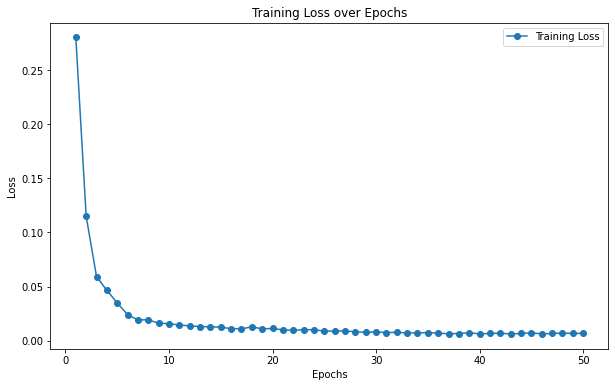

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

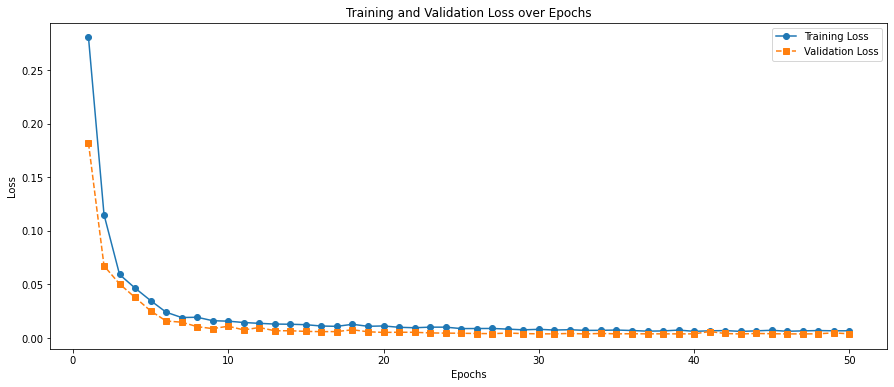

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Weddell_model_LT2/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 13ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.05638769711161948
MAE : 0.04706667133935948


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,4.187734e+06,4544849.638
1,5.218830e+06,5882741.038
2,5.882246e+06,6574288.749
3,6.116416e+06,6669726.076
4,6.024436e+06,6516136.854
5,5.339306e+06,5902163.675
6,3.825988e+06,3498103.449
7,1.511267e+06,1633675.726
8,9.204838e+05,1292668.399
9,1.288346e+06,1527666.815


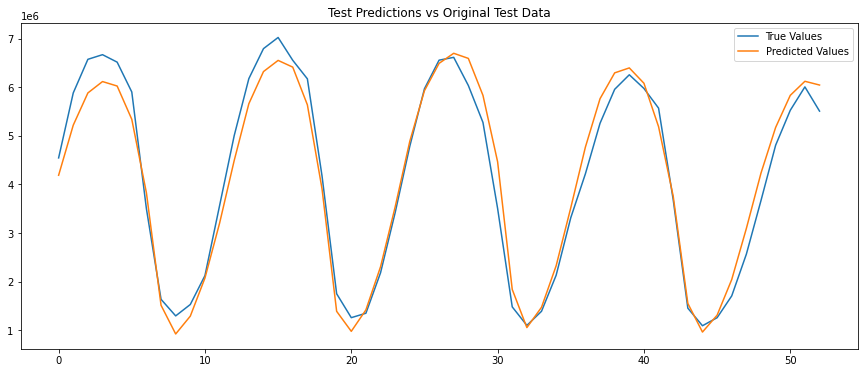

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

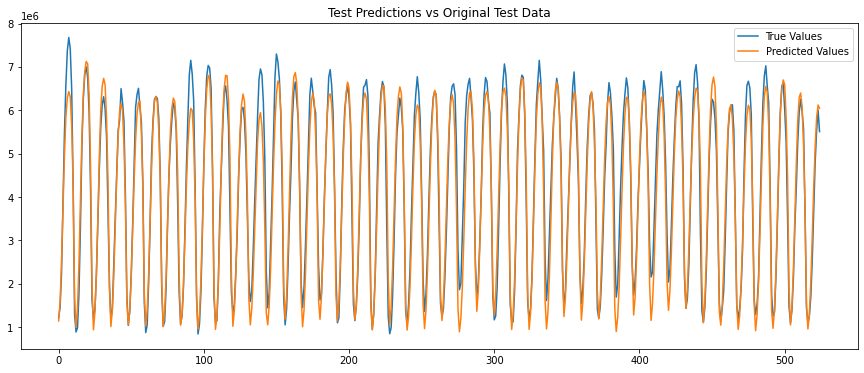

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()